# Double pendulum using Hamilton's equation

Defines a HamiltonianPendulum class that is used to generate double pendulum plots from solving Hamilton's equations.

Adapted from Dr. Furnstahl's Simple pendulum using Lagrange's Equation Notebook. 
Adapted by Keegan Doyle (Physics 5300)

Further adapted for the final problem set by Keegan Doyle.

## Hamilton's equations (NEEDS UPDATING)
### This corresponds to basic pendulum Hamiltonian

The generalized momentum corresponding to $\phi$ is

$\begin{align}
   \frac{\partial\mathcal{L}}{\partial \dot\phi} = m L^2 \dot\phi \equiv p_\phi
   \;.
\end{align}$

We can invert this equation to find $\dot\phi = p_\phi / m L^2$.
Constructing the Hamiltonian by Legendre transformation we find 

$\begin{align}
  \mathcal{H} &= \dot\phi p_\phi  - \mathcal{L} \\
              &= \frac{p_\phi^2}{m L^2} - \frac12 m L^2 \dot\phi^2 + mgL(1 - \cos\phi) \\
              &= \frac{p_\phi^2}{2 m L^2} + mgL(1 - \cos\phi)
              \;.
\end{align}$

Thus $\mathcal{H}$ is simply $T + V$.  Hamilton's equations are

$\begin{align}
  \dot\phi &= \frac{\partial\mathcal{H}}{\partial p_\phi} = \frac{p_\phi}{m L^2} \\
  \dot p_\phi &= -\frac{\partial\mathcal{H}}{\partial \phi} = -mgL \sin\phi 
  \;.
\end{align}$

In [22]:
%matplotlib inline

In [23]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [24]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Pendulum class and utility functions

In [75]:
class HamiltonianPendulum():
    """
    Pendulum class implements the parameters and Hamilton's equations for 
     a simple pendulum (no driving or damping).
     
    Parameters
    ----------
    L1 : float
        length of the first pendulum
    L2 : float
        length of the second pendulum
    g : float
        gravitational acceleration at the earth's surface
    omega_0n : float
        natural frequency of the pendulum (\sqrt{g/l} where l is the 
        pendulum length), and n is the pendulum number
    massn : float
        mass of pendulum, where n is the pendulum number

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1., L2=1., mass1=1., mass2=1., g=1.
                ):
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.omega1_0 = np.sqrt(g/L1)
        self.omega2_0 = np.sqrt(g/L2)
        self.mass1 = mass1
        self.mass2 = mass2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi1/dt dp_phi1/dt dphi2/dt dp_phi2/dt]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with 
            y[0] = phi1 and y[1] = p_phi1
            y[2] = phi2 and y[3] = p_phi2
            
        Returns
        -------
        
        """
        C1 = (y[1]*y[3]*np.sin(y[0]-y[2]))/ \
            (L1*L2*(mass1 + mass2*np.sin(y[0]-y[2])**2))
        
        C2 = np.sin(2.*(y[0]-y[2])) * ((L2**2 * mass2 * y[1]**2) + \
            (L1**2 * (mass1 + mass2) * y[3]**2) - \
            (L1*L2*mass2*y[1]*y[3]*np.cos(y[0]-y[2]))) / \
            2.* L1**2 * L2**2 *(mass1 + mass2*np.sin(y[0]-y[2])**2)**2
        
        return [(L2*y[1] - L1*y[3]*np.cos(y[0]-y[2]))/(L1**2 * L2 * (mass1 + mass2*np.sin(y[0]-y[2])**2)),
                -(mass1 + mass2)*g*L1*np.sin(y[0]) - C1 + C2,
                (L1*(mass1+mass2)*y[3] - L2*mass2*y[1]*np.cos(y[0]-y[2]))/(L1*L2**2 * (mass1+ mass2*np.sin(y[0]-y[2])**2)),
                -mass2*g*L2*np.sin(y[2]) + C1 - C2]
    
    def solve_ode(self, t_pts, phi1_0, p_phi1_0, phi2_0, p_phi2_0, 
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi1_0, p_phi1_0, phi2_0, p_phi2_0]
        
        solution1 = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        
        phi1, p_phi1, phi2, p_phi2 = solution1.y

        return phi1, p_phi1, phi2, p_phi2

In [76]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [77]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make double pendulum plots 

In [78]:
# Labels for individual plot axes
phi1_vs_time_labels = (r'$t$', r'$\phi(t)$')
phi2_vs_time_labels = (r'$t$', r'$\phi2(t)$')
p_phi1_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
p_phi2_vs_time_labels = (r'$t$', r'$d\phi2/dt(t)$')
state_space_labels = (r'$\phi$', r'$p\phi$')
state_space2_labels = (r'$\phi2$', r'$p\phi2$')


# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 30.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
g = 1.
mass1 = 1.
mass2 = 1.

# Instantiate a pendulum 
p1 = HamiltonianPendulum(L1=L1, L2=L2, g=g, mass1=mass1, mass2=mass2)


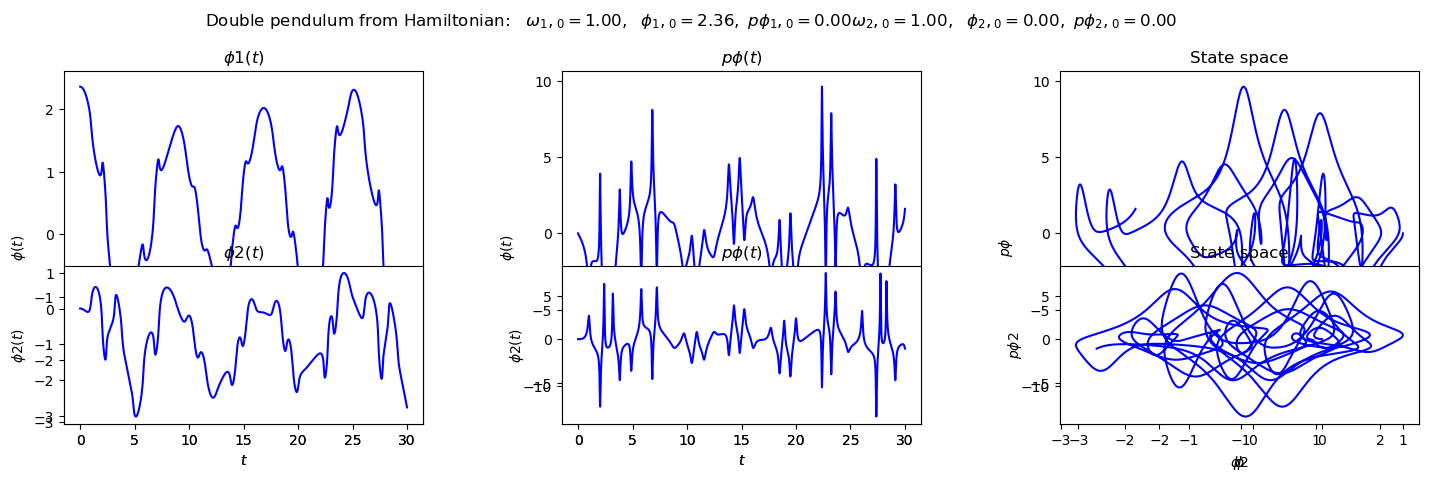

In [90]:
# both plots: same initial conditions
phi1_0 = (3./4.)*np.pi
p_phi1_0 = 0.
phi2_0 = 0.
p_phi2_0 = 0.
phi1, p_phi1, phi2, p_phi2 = p1.solve_ode(t_pts, \
                                          phi1_0, \
                                          p_phi1_0, \
                                          phi2_0, \
                                          p_phi2_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double pendulum from Hamiltonian:  ' + \
                rf' $\omega_1,_0 = {p1.omega1_0:.2f},$' + \
                rf'  $\phi_1,_0 = {phi1_0:.2f},$' + \
                rf' $p\phi_1,_0 = {p_phi1_0:.2f}$' + \
                rf'$\omega_2,_0 = {p1.omega2_0:.2f},$' + \
                rf'  $\phi_2,_0 = {phi2_0:.2f},$' + \
                rf' $p\phi_2,_0 = {p_phi2_0:.2f}$' + \
                '\n'    # \n means a new line (adds some space here)

fig.suptitle(overall_title, va='baseline')
    
# first plot: phi1 plot 
ax_a = fig.add_subplot(1,3,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi1_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\phi1(t)$', 
            ax=ax_a)    
                              
# second plot: p_phi1 plot 
ax_b = fig.add_subplot(1,3,2)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], p_phi1[start : stop], 
            axis_labels=phi1_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$p\phi(t)$', 
            ax=ax_b)    

# third plot: First Pendulum state space plot from t=0 to t=30   
ax_c = fig.add_subplot(1,3,3)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(phi1[start : stop], p_phi1[start : stop], 
            axis_labels=state_space_labels, 
            color='blue',
            label=None, 
            title='State space', 
            ax=ax_c)

# fourth plot: phi2(t) from t=0 to t= 30
ax_d = fig.add_subplot(2,3,4)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
            axis_labels=phi2_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\phi2(t)$', 
            ax=ax_d)

# fifth plot: p_phi2 plot 
ax_e = fig.add_subplot(2,3,5)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], p_phi2[start : stop], 
            axis_labels=phi2_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$p\phi(t)$', 
            ax=ax_e)

# sixth plot: Second Pendulum state space plot from t=0 to t=30   
ax_f = fig.add_subplot(2,3,6)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(phi2[start : stop], p_phi2[start : stop], 
            axis_labels=state_space2_labels, 
            color='blue',
            label=None, 
            title='State space', 
            ax=ax_f)

fig.tight_layout()
fig.savefig('double_pendulum_Hamilton.png', bbox_inches='tight')  

Now trying the power spectrum, plotting only positive frequencies and cutting off the lower peaks:

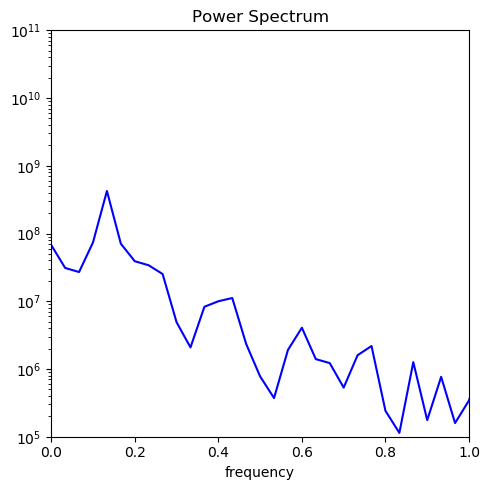

In [83]:
start, stop = start_stop_indices(t_pts, t_start, t_end)    
signal = phi1[start:stop]
power_spectrum = np.abs(np.fft.fft(signal))**2
freqs = np.fft.fftfreq(signal.size, delta_t)
idx = np.argsort(freqs)

fig_ps = plt.figure(figsize=(5,5))
ax_ps = fig_ps.add_subplot(1,1,1)
ax_ps.semilogy(freqs[idx], power_spectrum[idx], color='blue')
ax_ps.set_xlim(0, 1.)
ax_ps.set_ylim(1.e5, 1.e11)
ax_ps.set_xlabel('frequency')
ax_ps.set_title('Power Spectrum')

fig_ps.tight_layout()